In [1]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-4vgltj_p
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-4vgltj_p
  Resolved https://github.com/paulgavrikov/visualkeras to commit 8d42f3a9128373eac7b4d38c23a17edc9357e3c9
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 9.3 MB/s eta 0:00:00
  Created wheel for visualkeras: filename=visualkeras-0.1.4-py3-none-any.whl size=17145 sha256=6c384045263a99e5f46625306cab89c2a2d0d5ab32c00db85e99f6fab165e65f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cpubk5qc/wheels/be/f7/2b/90cdf278d2022271c504be10866520c5d94d4a82c919b77302
Successfully built visualkeras


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
import librosa.display
import os

import IPython
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import visualkeras

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## The Dataset - GTZAN

- Instances (m): 1,000
- Squence length (per instance): 30 sec
- Labels: 10 (Blues, Classical, Country, Disco, Hip hop, Jazz, Metal, Pop, Reggae, Rock)

Preparing the dataset.


### Steps
1. Create the dataset. Feature Engineering
2. Fit the CNN to the dataset
3. Evaluate the performance

### Creating the dataset
Based on the different resources I am finding online (Kaggle and some blog posts), it seems like the way to go is to extract meaningful features from the data, shape them so that they share dimensions and build a tensor out of them.
The most interesting feature was the Mel-Spectogram

## 1. Setup, Data, Feature Engineering

In [3]:
import kagglehub
import shutil
import os


# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)


# Define the target path
target_path = '/kaggle/working/gtzan-dataset-music-genre-classification'
os.makedirs(target_path, exist_ok=True)

# Move files from the download location to the target path
shutil.move(path, target_path)

print("Dataset successfully moved to:", target_path)

# print("Path to dataset files:", download_path)


100%|██████████| 1.21G/1.21G [00:14<00:00, 92.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
Dataset successfully moved to: /kaggle/working/gtzan-dataset-music-genre-classification


In [10]:
# Setup: path, one-hot vector for the labels
# ----------------

path =  r"/kaggle/working/gtzan-dataset-music-genre-classification/1/Data/genres_original"
labels = [f.name for f in os.scandir(path) if f.is_dir()]
n_files = 0
# One-hot vector for the labels
indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

for folder in labels:
    folder_path = os.path.join(path, folder)  # Ensures proper path formatting
    files = os.listdir(folder_path)  # List files in the correct folder
    for file in files:
        if file.endswith('.wav'):
            n_files += 1


print("Number of files : ", n_files)

['country', 'classical', 'reggae', 'rock', 'metal', 'hiphop', 'pop', 'jazz', 'blues', 'disco']
country [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
classical [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
reggae [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
rock [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
metal [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
hiphop [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
pop [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
jazz [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
blues [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
disco [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Number of files :  1000


In [6]:
# Global variables
# ----------------

H = 128 # height of the tensor

N_FEATURES = 1 # Channels of the tensor
N_FILES = n_files
AUG_FEATURES = 5
N_SLICES = 3
M = N_FILES * N_SLICES * (AUG_FEATURES + 1) # Number of instances after the feature transform


In [23]:
import os
import librosa
import h5py
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Constants
SAMPLE_RATE = 22050   # Standard sample rate for GTZAN dataset
DURATION = 30         # Length of each track in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION  # Total samples per track
N_MELS = 128          # Number of Mel bands
N_FFT = 2048          # FFT window size
HOP_LENGTH = 512      # Hop length for spectrogram
NUM_SEGMENTS = 5      # Split each track into 5 parts

# Function to compute Log-Mel Spectrogram
def compute_log_mel(signal, sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Compute Log-Mel Spectrogram and apply normalization.
    """
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize using Min-Max Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    log_mel_spec = scaler.fit_transform(log_mel_spec)  # Normalize per spectrogram

    return log_mel_spec.T  # Transpose to (time_frames, features)

# Function to preprocess dataset and store in HDF5
def save_log_mel_hdf5(dataset_path, hdf5_path, num_segments=NUM_SEGMENTS):
    """
    Process dataset and save Log-Mel Spectrograms into an HDF5 file.

    Args:
        dataset_path (str): Path to the dataset folder containing genre subdirectories.
        hdf5_path (str): Path to save the HDF5 file.
        num_segments (int): Number of segments to split each track.
    """
    data = {"mapping": [], "features": [], "labels": []}
    samples_per_segment = SAMPLES_PER_TRACK // num_segments
    expected_frames_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

    # Scan all genres in dataset path
    genre_list = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    data["mapping"] = genre_list
    print(f"✅ Genre Mapping: {data['mapping']}")

    # Process each genre folder
    for genre in genre_list:
        genre_path = os.path.join(dataset_path, genre)
        label = data["mapping"].index(genre)  # Convert genre to integer label
        print(f"🎵 Processing {genre}...")

        for filename in os.listdir(genre_path):
            if not filename.endswith(".wav"):
                continue

            file_path = os.path.join(genre_path, filename)
            try:
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            except Exception as e:
                print(f"🚨 Error loading {file_path}: {e}")
                continue

            for s in range(num_segments):
                start_sample = samples_per_segment * s
                finish_sample = start_sample + samples_per_segment

                if len(signal[start_sample:finish_sample]) < samples_per_segment * 0.8:
                    continue  # Ignore if segment is too short

                # Compute Log-Mel Spectrogram
                log_mel = compute_log_mel(signal[start_sample:finish_sample], sr)

                # Ensure consistent shape by padding/trimming
                if log_mel.shape[0] > expected_frames_per_segment:
                    log_mel = log_mel[:expected_frames_per_segment, :]
                else:
                    pad_width = expected_frames_per_segment - log_mel.shape[0]
                    log_mel = np.pad(log_mel, ((0, pad_width), (0, 0)), mode='constant')

                data["features"].append(log_mel.tolist())
                data["labels"].append(label)

    # Save to HDF5
    if len(data["features"]) > 0:
        print(f"✅ Saving {len(data['features'])} samples to {hdf5_path}...")
        with h5py.File(hdf5_path, "w") as hf:
            hf.create_dataset("features", data=np.array(data["features"]), compression="gzip")
            hf.create_dataset("labels", data=np.array(data["labels"], dtype=np.int32), compression="gzip")
            hf.create_dataset("mapping", data=np.array(data["mapping"], dtype="S"), compression="gzip")
        print("✅ Data successfully saved to HDF5!")
    else:
        print("🚨 No valid data to save!")

# Function to load preprocessed data from HDF5
def load_log_mel_hdf5(hdf5_path):
    """
    Load Log-Mel Spectrogram data from HDF5 file.

    Args:
        hdf5_path (str): Path to HDF5 file.

    Returns:
        Tuple (X, Y, genre_mapping)
    """
    with h5py.File(hdf5_path, "r") as hf:
        X = np.array(hf["features"])
        Y = np.array(hf["labels"])
        mapping = [m.decode("utf-8") for m in hf["mapping"]]

    print(f"✅ Loaded dataset: {X.shape[0]} samples, {X.shape[1:]} feature shape")
    return X, Y, mapping


In [24]:
# import os
# import numpy as np
# import librosa as lb
# import librosa.display
# import h5py

# # Constants
# N_SLICES = 5  # Adjust for splitting samples
# N_MELS = 128  # Number of Mel filterbanks
# HOP_LENGTH = 512  # Determines time resolution of spectrogram

# def compute_log_mel(sample, sr):
#     """
#     Convert raw audio sample to a log Mel spectrogram with a fixed shape.
#     """
#     mel_spec = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=128, hop_length=512)
#     log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

#     # Standardize shape
#     if log_mel_spec.shape[1] > FIXED_TIME_FRAMES:
#         log_mel_spec = log_mel_spec[:, :FIXED_TIME_FRAMES]  # Trim excess frames
#     else:
#         pad_width = FIXED_TIME_FRAMES - log_mel_spec.shape[1]
#         log_mel_spec = np.pad(log_mel_spec, ((0, 0), (0, pad_width)), mode='constant')

#     return log_mel_spec

# def process_and_store_mel_spectrograms(path, folders, output_file="dataset_mel.h5"):
#     """
#     Reads audio files, converts to log Mel spectrograms, and saves them in an HDF5 file.
#     """
#     input_length = None
#     for folder in folders:
#         files = [f for f in os.listdir(os.path.join(path, folder)) if f.endswith('.wav')]
#         if files:
#             sample, sr = librosa.load(os.path.join(path, folder, files[0]), sr=None)
#             input_length = compute_log_mel(sample, sr).shape[1]  # Number of time frames
#             break

#     if input_length is None:
#         raise ValueError("No valid WAV files found.")

#     total_samples = sum(len([f for f in os.listdir(os.path.join(path, folder)) if f.endswith('.wav')])
#                         * N_SLICES for folder in folders)

#     with h5py.File(output_file, "w") as f:
#         X_dataset = f.create_dataset("X", (total_samples, N_MELS, input_length), dtype=np.float32)
#         Y_dataset = f.create_dataset("Y", (total_samples, 10), dtype=np.uint8)

#         idx = 0
#         for folder in folders:
#             print(f"Processing {folder}...")
#             files = [f for f in os.listdir(os.path.join(path, folder)) if f.endswith('.wav')]
#             for file in files:
#                 sample, sr = librosa.load(os.path.join(path, folder, file), sr=None)
#                 mel_spec = compute_log_mel(sample, sr)

#                 X_dataset[idx] = mel_spec
#                 Y_dataset[idx] = oh_dict[folder]  # One-hot encoding
#                 idx += 1

#                 if idx % 100 == 0:
#                     print(f"Processed {idx}/{total_samples} samples...")

#         print(f"Mel spectrogram dataset stored in {output_file}.")

# def load_mel_spectrograms(file="dataset_mel.h5"):
#     """
#     Load log Mel spectrograms from HDF5.
#     """
#     with h5py.File(file, "r") as f:
#         X = f["X"][:]
#         Y = f["Y"][:]
#     return X, Y


In [25]:
# process_and_store_mel_spectrograms(path, labels)


In [27]:
# X, Y = load_data_from_hdf5("dataset.h5")

In [26]:
  # Change this to your dataset folder
hdf5_path = "log_mel_features.h5"  # Output file

save_log_mel_hdf5(path, hdf5_path)


✅ Genre Mapping: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
🎵 Processing blues...
🎵 Processing classical...
🎵 Processing country...
🎵 Processing disco...
🎵 Processing hiphop...
🎵 Processing jazz...


<ipython-input-23-34224f7ff3c6>:62: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


🚨 Error loading /kaggle/working/gtzan-dataset-music-genre-classification/1/Data/genres_original/jazz/jazz.00054.wav: 
🎵 Processing metal...
🎵 Processing pop...
🎵 Processing reggae...
🎵 Processing rock...
✅ Saving 4995 samples to log_mel_features.h5...
✅ Data successfully saved to HDF5!


In [28]:
X, Y, genres = load_log_mel_hdf5("log_mel_features.h5")

print("Feature shape:", X.shape)  # (num_samples, time_frames, 128)
print("Labels shape:", Y.shape)  # (num_samples,)
print("Genres:", genres)  # List of genre names


✅ Loaded dataset: 4995 samples, (259, 128) feature shape
Feature shape: (4995, 259, 128)
Labels shape: (4995,)
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


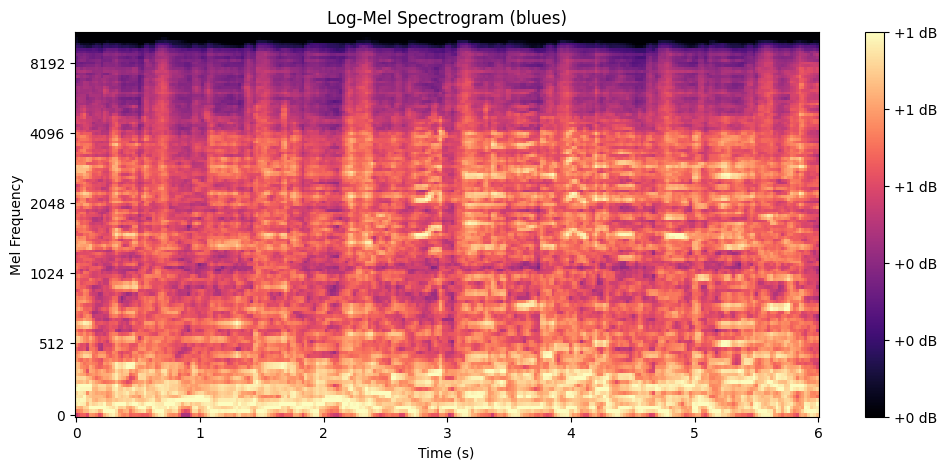

In [30]:
import matplotlib.pyplot as plt
import librosa.display

def plot_log_mel_spectrogram(index, X, Y, genres):
    """
    Plots a Log-Mel Spectrogram from the dataset.

    Args:
        index (int): Index of the sample to plot.
        X (numpy.ndarray): Loaded spectrogram dataset.
        Y (numpy.ndarray): Corresponding labels.
        genres (list): Genre mapping.
    """
    log_mel_spec = X[index].T  # Transpose back to (n_mels, time_frames)
    genre = genres[Y[index]]

    plt.figure(figsize=(12, 5))
    librosa.display.specshow(log_mel_spec, sr=22050, hop_length=512, cmap="magma", x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Log-Mel Spectrogram ({genre})")
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.show()

# Plot a random sample
sample_index = np.random.randint(0, len(X))  # Pick a random index
plot_log_mel_spectrogram(sample_index, X, Y, genres)


In [31]:
# plt.plot(X[:,0])

In [32]:
# # Run only if we are loading the data

# x_raw = np.load('../data/x_raw_3_slice.npy')
# y_raw = np.load('../data/y_raw_3_slice.npy')
# _,sr = read_sample(path+'blues/'+'blues.00000.wav')

In [18]:
X.shape

(5000, 132358)

In [33]:
# # Creating the tensor with the features
# # -----------

# X = create_dataset(x_raw, sr)
# Y = np.copy(y_raw)
# print(X.shape)
# print(Y.shape)

In [34]:
# assert X.shape[0] == Y.shape[0], "X, Y shapes don't match"
# assert Y.shape[1] == len(labels), "Y shape doesn't match the shape of the labels"

In [35]:
# # Train, validation, test split
# # ------------
# # 80% for training, 10% for validation and 10% for testing

# x_train, x_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
# x_val, x_test, y_val, y_test = train_test_split(x_test_valid,y_test_valid, test_size=0.5)

# print(f'Train: {x_train.shape} {y_train.shape}')
# print(f'Valid: {x_val.shape}   {y_val.shape}')
# print(f'Test:  {x_test.shape}  {y_test.shape}')


In [36]:
from sklearn.model_selection import train_test_split

def split_data(X, Y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split dataset into training, validation, and test sets.

    Args:
        X (numpy.ndarray): Features (log-mel spectrograms).
        Y (numpy.ndarray): Labels (genre indices).
        test_size (float): Proportion of test set (default 20%).
        val_size (float): Proportion of validation set (default 10%).
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train, X_val, X_test, Y_train, Y_val, Y_test
    """
    # Split into Train + Temp (Validation + Test)
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=test_size + val_size, random_state=random_state, stratify=Y)

    # Split Temp into Validation + Test
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=test_size / (test_size + val_size), random_state=random_state, stratify=Y_temp)

    print(f"✅ Train set: {X_train.shape[0]} samples")
    print(f"✅ Validation set: {X_val.shape[0]} samples")
    print(f"✅ Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Load Data
X, Y, genres = load_log_mel_hdf5("log_mel_features.h5")

# Split Data
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_data(X, Y)


✅ Loaded dataset: 4995 samples, (259, 128) feature shape
✅ Train set: 3496 samples
✅ Validation set: 749 samples
✅ Test set: 750 samples


<ipython-input-37-df94055f2fdd>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(genres, rotation=45)
<ipython-input-37-df94055f2fdd>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(genres, rotation=45)
<ipython-input-37-df94055f2fdd>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(genres, rotation=45)


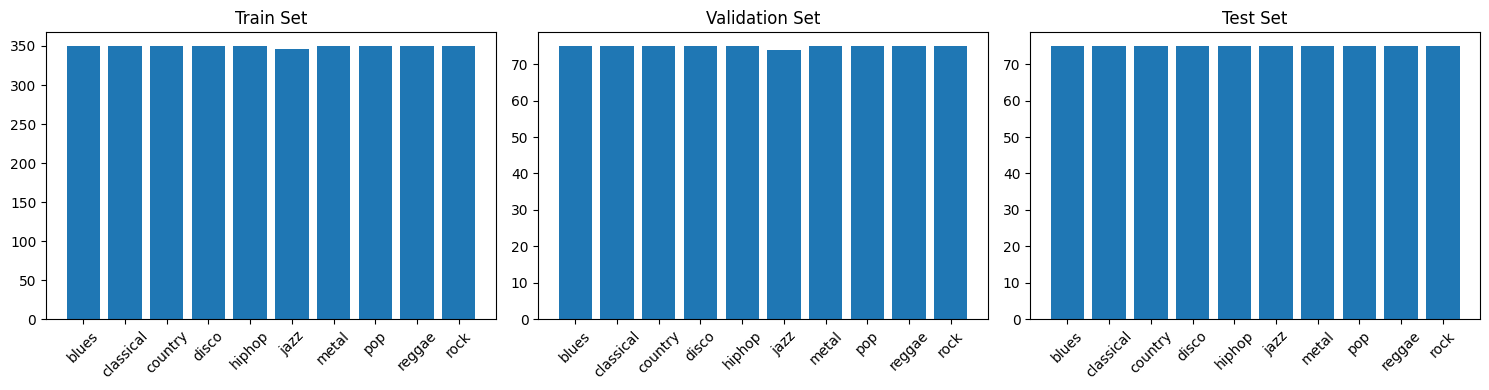

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(Y_train, Y_val, Y_test, genres):
    """
    Plot bar charts of genre distribution in Train, Val, and Test sets.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, Y, title in zip(axes, [Y_train, Y_val, Y_test], ["Train", "Validation", "Test"]):
        unique, counts = np.unique(Y, return_counts=True)
        ax.bar([genres[i] for i in unique], counts)
        ax.set_title(f"{title} Set")
        ax.set_xticklabels(genres, rotation=45)

    plt.tight_layout()
    plt.show()

# Check the genre distribution
plot_class_distribution(Y_train, Y_val, Y_test, genres)


In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define Model
n_filters = 64
input_shape = (X_train.shape[1], X_train.shape[2], 1)
inputs = keras.Input(shape=input_shape)

# Resize Input for Consistency
x = layers.Resizing(128, 128)(inputs)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

# Compile Model
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(),  # For integer labels
    metrics=['accuracy']
)

# Define Callbacks for Efficient Training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train Model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=100,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop, lr_scheduler]  # Automatic stopping & learning rate scheduling
)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"🟢 Final Test Accuracy: {test_acc:.4f}")


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.1293 - loss: 2.3035 - val_accuracy: 0.2657 - val_loss: 1.9933 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.2716 - loss: 1.9890 - val_accuracy: 0.3752 - val_loss: 1.7678 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.3687 - loss: 1.7603 - val_accuracy: 0.4806 - val_loss: 1.4540 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.4578 - loss: 1.5068 - val_accuracy: 0.4286 - val_loss: 1.4861 - learning_rate: 0.0010
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.4763 - loss: 1.4178 - val_accuracy: 0.5127 - val_loss: 1.2828 - learning_rate: 0.0010
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.5163 - loss: 1.2770 - val_accuracy: 0.5888 - val_loss: 1.1577 - learning_rate: 0.0010
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.5486 - l

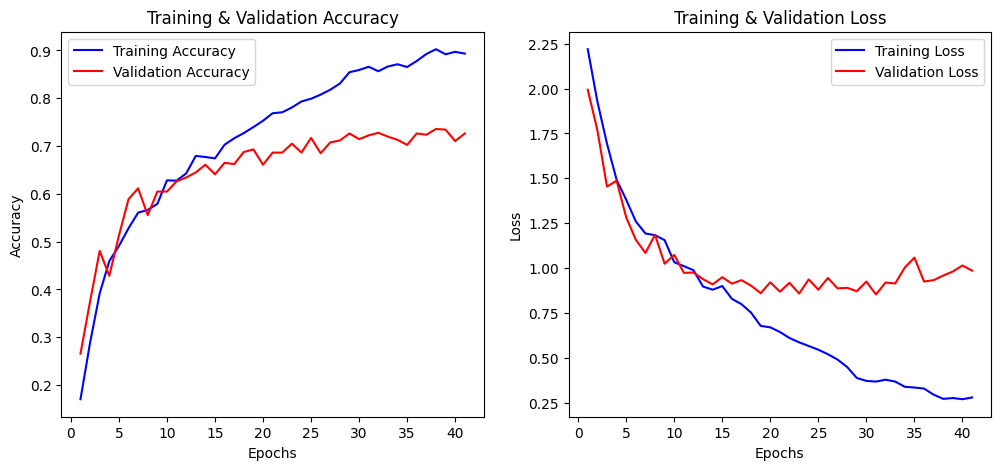

In [40]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training & validation accuracy and loss.

    Args:
        history: Keras history object after model training.
    """
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.show()

# Call the function
plot_training_history(history)


24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 609ms/step


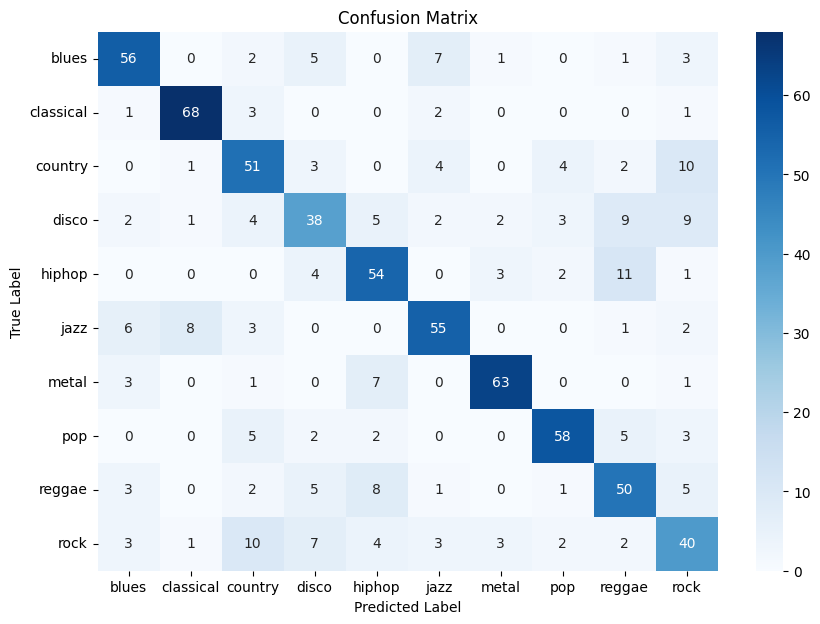

In [41]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, Y_test, genres):
    """
    Plots a confusion matrix heatmap.

    Args:
        model: Trained model.
        X_test: Test data.
        Y_test: True labels.
        genres: List of class labels.
    """
    # Get predictions
    Y_pred = np.argmax(model.predict(X_test), axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)

    # Plot heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function
plot_confusion_matrix(model, X_test, Y_test, genres)


In [42]:
# # Save the model
# model.save("music_genre_classification_model.h5")

# print("✅ Model saved successfully!")
